To start our analysis, we import several external libraries of interest

In [1]:

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from tools import utils
import torch
import numpy as np
import pandas as pd
from sklearn import decomposition, manifold
from sklearn.cluster import KMeans

scaler = torch.cuda.amp.GradScaler()

We then define functions to perform dimensionality reduction and kmeans clustering

In [47]:
def dimension_reductions(data_table):
    mean = np.mean(data_table, axis=0)
    std = np.std(data_table, axis=0)
    norm_data = (data_table - mean) / std
    pca_obj = decomposition.PCA(n_components=2)
    pca = pca_obj.fit_transform(norm_data)
    tsne = manifold.TSNE().fit_transform(norm_data)
    names = ['PC1', 'PC2', 'tSNE-0', 'tSNE-1']
    return np.hstack((pca, tsne)), names, pca_obj.components_


def kmeans_clustering_plot(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    labels = kmeans.labels_
    pca = decomposition.PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels)
    plt.show()
    return labels

Following that, the user has to use a pretrained model to generate image embeddings. Please check https://github.com/agporto/DeepBryo/ for an example

In [28]:
# Define the parameters of the model 
ckpt_pretrained = 'path/to/weigths'
data_dir = 'path/to/images'
num_classes = 5 
batch_sizes = {
    "train_batch_size": 2,
    'valid_batch_size': 2
}
num_workers = 32
backbone = 'swin_transformer'

# load the pytorch model and place it in eval mode
transforms = utils.build_transforms(second_stage=False, img_size = 384)
loaders = utils.build_loaders(data_dir, transforms, batch_sizes, num_workers, second_stage=False)
model = utils.build_model(backbone, second_stage=False, num_classes=num_classes, ckpt_pretrained=ckpt_pretrained).cuda()
model.use_projection_head(False)
model.eval()

# Generate embeddings for the images of interest
embeddings, labels = utils.compute_embeddings(loaders['valid_loader'], model, scaler)
paths= [item[0] for item in loaders['valid_loader'].dataset.imgs]
reduced_data, colnames, _ = dimension_reductions(embeddings)



In [ ]:
# Create a dataframe with the reduced data
df = pd.DataFrame(reduced_data, columns=colnames)
df['paths'] = paths
df['class'] = labels
df['class_str']=[item[0].split('/')[-2] for item in loaders['valid_loader'].dataset.imgs]


We are ready to perform kmeans clustering

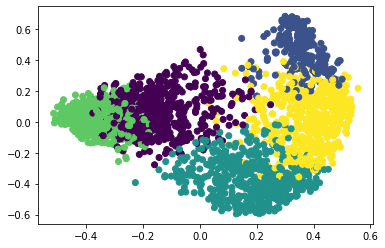

In [33]:
labels = kmeans_clustering_plot(embeddings,5)

We can then isolate the images of interest from the rest

In [ ]:
selection = df.iloc(labels==3)

In [ ]:
selection.to_csv('imageSelection.csv')